# 3D Building Data Extraction for Menara LGB Area

This notebook demonstrates how to extract building footprints, heights, and elevation data around Menara LGB office for urban tree planning.

## Why 3D Data Matters for Tree Planning:
- **Shadow Analysis**: Tall buildings cast shadows → less need for shade trees
- **Spacing**: Know building locations → find planting spaces between buildings
- **Elevation**: Low areas flood → prioritize water-absorbing trees
- **Visualization**: Show 3D before/after models to city council

In [ ]:
# Import required libraries
import sys
from pathlib import Path
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd

# Add parent directory to path to import config
parent_dir = Path().absolute().parent
sys.path.insert(0, str(parent_dir))

# Import project configuration
import config

# Configure OSMnx
ox.settings.use_cache = config.USE_CACHE
ox.settings.log_console = config.LOG_CONSOLE

print(f"OSMnx version: {ox.__version__}")
print(f"✅ Config loaded successfully!")
print(f"   - Project root: {config.PROJECT_ROOT}")
print(f"   - Menara LGB coords: {config.MENARA_LGB_COORDS}")
print(f"   - Study radius: {config.STUDY_RADIUS}m")

## Part 1: Define Menara LGB Project Area

In [ ]:
# Menara LGB coordinates - EXACT LOCATION (from config.py)
# Menara LGB (Lembaga Getah Malaysia Building)
menara_lgb_coords = config.MENARA_LGB_COORDS
study_radius = config.STUDY_RADIUS

print(f"Study area: {study_radius}m radius around Menara LGB")
print(f"Coordinates: {menara_lgb_coords}")
print(f"")
print(f"📍 Using configuration from config.py")
print(f"   - All team members will use the same coordinates")
print(f"   - Distance thresholds: {config.DISTANCE_FAR_FROM_BUILDING}m (far), {config.DISTANCE_NEAR_BUILDING}m (near)")

## Part 2: Extract Building Footprints with Heights

OSMnx can download building footprints from OpenStreetMap. Some buildings have height data in tags.

In [3]:
# Download building footprints around Menara LGB
tags = {'building': True}  # Get all buildings

buildings = ox.features_from_point(
    menara_lgb_coords,
    tags=tags,
    dist=study_radius
)

print(f"Found {len(buildings)} buildings in the area")
print(f"\nBuilding data columns: {buildings.columns.tolist()}")

Found 1042 buildings in the area

Building data columns: ['geometry', 'addr:city', 'addr:postcode', 'addr:street', 'building', 'disused:amenity', 'name', 'name:en', 'amenity', 'name:ms', 'name:zh', 'name:zh-Hans', 'name:zh-Hant', 'addr:housenumber', 'brand', 'brand:wikidata', 'brand:wikipedia', 'cuisine', 'diet:halal', 'takeaway', 'building:levels', 'height', 'healthcare', 'full_name', 'layer', 'name:short', 'name:ta', 'network', 'operator', 'public_transport', 'railway', 'ref', 'station', 'subway', 'website', 'wikidata', 'wikipedia', 'building:flats', 'alt_name', 'amenity_1', 'religion', 'abandoned', 'construction', 'house', 'atm', 'shop', 'level', 'branch', 'addr:country', 'dispensing', 'short_name', 'musical_instrument:type', 'source', 'strapline', 'emergency', 'office', 'studio', 'delivery', 'operator:wikidata', 'operator:wikipedia', 'description', 'healthcare:speciality', 'laundry_service', 'organic', 'outdoor_seating', 'furniture', 'dance:teaching', 'leisure', 'phone', 'disused:s

In [4]:
# Check what height information is available
height_columns = [col for col in buildings.columns if 'height' in col.lower() or 'level' in col.lower()]
print(f"Height-related columns: {height_columns}")

# Display sample of buildings with height data
if 'height' in buildings.columns or 'building:levels' in buildings.columns:
    height_cols = ['name'] + height_columns + ['geometry']
    available_cols = [col for col in height_cols if col in buildings.columns]
    print("\nSample buildings with height data:")
    display(buildings[available_cols].head(10))
else:
    print("\nNote: Height data may not be available for all buildings in OpenStreetMap")

Height-related columns: ['building:levels', 'height', 'level']

Sample buildings with height data:


name building:levels height  \
element id                                                                   
node    9290748167   Tapak Urban Street Dining TTDI             NaN    NaN   
way     27697470    Pasar Besar Taman Tun Dr Ismail             NaN    NaN   
        27697574                          Pizza Hut             NaN    NaN   
        142497241                        Menara LGB              31    130   
        262190434                        TTDI Plaza               3    NaN   
        262190665             Bangunan Bakti Hasmah             NaN    NaN   
        262861169                               NaN              24    112   
        262962312                               NaN             NaN    NaN   
        262962357                               NaN             NaN    NaN   
        262962369                               NaN             NaN    NaN   

                   level                                           geometry  
element id                                                                   
node    9290748167   NaN                          POINT (101.62798 3.14105)  
way     27697470     NaN  POLYGON ((101.62938 3.13843, 101.62915 3.13908...  
        27697574     NaN  POLYGON ((101.62815 3.1389, 101.62807 3.13913,...  
        142497241    NaN  POLYGON ((101.62985 3.13769, 101.62963 3.13798...  
        262190434    NaN  POLYGON ((101.63043 3.13738, 101.63017 3.13799...  
        262190665    NaN  POLYGON ((101.63266 3.14245, 101.63328 3.14246...  
        262861169    NaN  POLYGON ((101.63039 3.13944, 101.63044 3.13953...  
        262962312    NaN  POLYGON ((101.63087 3.14014, 101.63094 3.13995...  
        262962357    NaN  POLYGON ((101.63132 3.13999, 101.63166 3.14008...  
        262962369    NaN  POLYGON ((101.63101 3.13981, 101.63121 3.13988...

## Part 3: Process Building Heights

OpenStreetMap buildings may have:
- `height` tag (in meters)
- `building:levels` tag (number of floors)

We'll estimate heights where data is missing.

In [5]:
# Function to estimate building height
def estimate_building_height(row):
    """
    Estimate building height in meters.
    Priority: height tag > building:levels * 3.5m > default 15m
    """
    # Try direct height tag
    if 'height' in row and pd.notna(row['height']):
        try:
            # Handle "23.5 m" or "23.5" format
            height_str = str(row['height']).replace(' m', '').replace('m', '')
            return float(height_str)
        except:
            pass
    
    # Try building:levels tag (assume 3.5m per floor)
    if 'building:levels' in row and pd.notna(row['building:levels']):
        try:
            levels = float(row['building:levels'])
            return levels * 3.5  # Standard floor height
        except:
            pass
    
    # Default estimate based on building type
    building_type = row.get('building', 'yes')
    if building_type in ['commercial', 'office', 'retail']:
        return 20.0  # Assume mid-rise commercial
    elif building_type in ['residential', 'apartments']:
        return 15.0  # Assume mid-rise residential
    else:
        return 10.0  # Default for unknown buildings

# Apply height estimation
buildings['estimated_height_m'] = buildings.apply(estimate_building_height, axis=1)

print("Height estimation summary:")
print(buildings['estimated_height_m'].describe())
print(f"\nTallest building: {buildings['estimated_height_m'].max():.1f}m")
print(f"Average building height: {buildings['estimated_height_m'].mean():.1f}m")

Height estimation summary:
count    1042.000000
mean       13.672745
std        11.074215
min         3.500000
25%        10.000000
50%        10.000000
75%        15.000000
max       134.000000
Name: estimated_height_m, dtype: float64

Tallest building: 134.0m
Average building height: 13.7m


## Part 4: Visualize Buildings with Height

Color buildings by height to understand the 3D landscape.

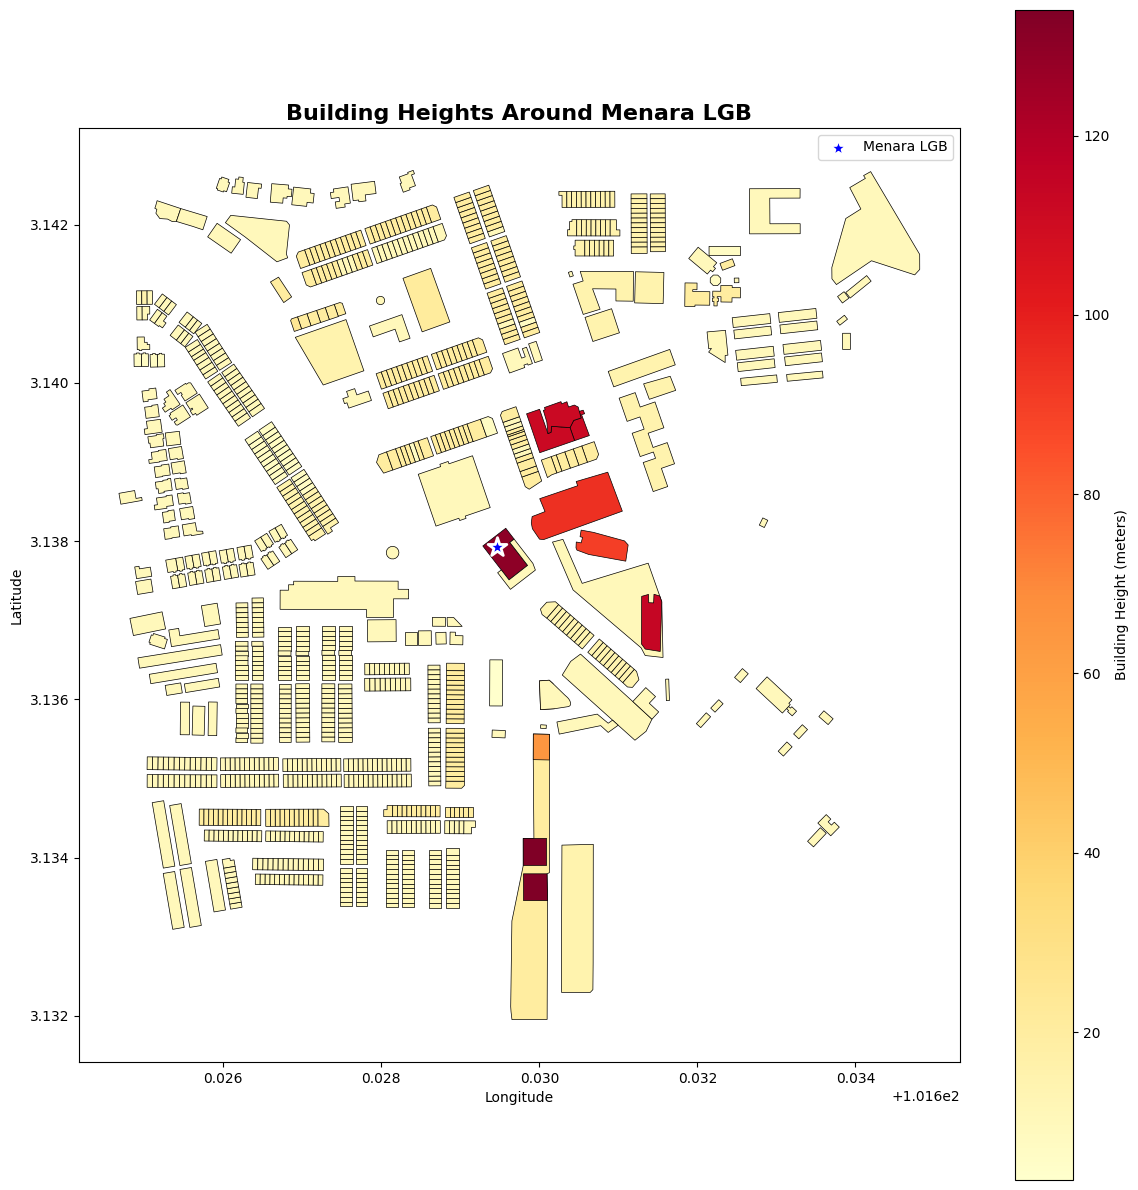

In [6]:
# Create visualization
fig, ax = plt.subplots(figsize=(12, 12))

# Plot buildings colored by height
buildings.plot(
    ax=ax,
    column='estimated_height_m',
    cmap='YlOrRd',
    legend=True,
    legend_kwds={'label': 'Building Height (meters)'},
    edgecolor='black',
    linewidth=0.5
)

# Mark Menara LGB location
ax.scatter(
    menara_lgb_coords[1], 
    menara_lgb_coords[0],
    c='blue',
    s=200,
    marker='*',
    label='Menara LGB',
    zorder=10,
    edgecolor='white',
    linewidth=2
)

ax.set_title('Building Heights Around Menara LGB', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()

plt.tight_layout()
plt.show()

In [7]:
# Download street networks for different modes
from shapely.geometry import LineString

print("Downloading street networks...")

# 1. Walking network (pedestrian paths, sidewalks)
G_walk = ox.graph_from_point(
    menara_lgb_coords,
    dist=study_radius,
    network_type='walk'
)

# 2. Driving network (roads for vehicles)
G_drive = ox.graph_from_point(
    menara_lgb_coords,
    dist=study_radius,
    network_type='drive'
)

print(f"✅ Walk network: {len(G_walk.nodes())} nodes, {len(G_walk.edges())} edges")
print(f"✅ Drive network: {len(G_drive.nodes())} nodes, {len(G_drive.edges())} edges")

# Analyze street types from walking network
print("\nAnalyzing street types...")
street_types = {}
street_edges_by_type = {}

for u, v, key, data in G_walk.edges(keys=True, data=True):
    # Get highway type (road classification)
    highway = data.get('highway', 'unknown')
    
    # Handle list of highway types (take first one)
    if isinstance(highway, list):
        highway = highway[0]
    
    if highway not in street_types:
        street_types[highway] = 0
        street_edges_by_type[highway] = []
    
    street_types[highway] += 1
    
    # Store edge geometry
    if 'geometry' in data:
        street_edges_by_type[highway].append(data['geometry'])
    else:
        u_coords = (G_walk.nodes[u]['x'], G_walk.nodes[u]['y'])
        v_coords = (G_walk.nodes[v]['x'], G_walk.nodes[v]['y'])
        street_edges_by_type[highway].append(LineString([u_coords, v_coords]))

# Print street type distribution
print("\n" + "="*60)
print("STREET TYPE DISTRIBUTION")
print("="*60)
for street_type, count in sorted(street_types.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / sum(street_types.values())) * 100
    priority = 'HIGH' if street_type in ['primary', 'secondary'] else \
               'MEDIUM' if street_type in ['tertiary', 'residential'] else 'LOW'
    print(f"{street_type:20s}: {count:4d} ({percentage:5.1f}%) - {priority} priority")
print("="*60)
print(f"\n✅ Street network data ready for visualization!")

✅ Walk network: 469 nodes, 1350 edges
✅ Drive network: 170 nodes, 350 edges

Analyzing street types...

STREET TYPE DISTRIBUTION
service             :  338 ( 25.0%) - LOW priority
unclassified        :  330 ( 24.4%) - LOW priority
residential         :  272 ( 20.1%) - MEDIUM priority
footway             :  217 ( 16.1%) - LOW priority
secondary           :   66 (  4.9%) - HIGH priority
primary             :   64 (  4.7%) - HIGH priority
primary_link        :   18 (  1.3%) - LOW priority
tertiary            :   14 (  1.0%) - MEDIUM priority
path                :   12 (  0.9%) - LOW priority
steps               :   11 (  0.8%) - LOW priority
secondary_link      :    8 (  0.6%) - LOW priority

✅ Street network data ready for visualization!


## Part 4B: Download and Analyze Street Networks

Now let's download street networks to understand pedestrian and vehicle pathways around Menara LGB.

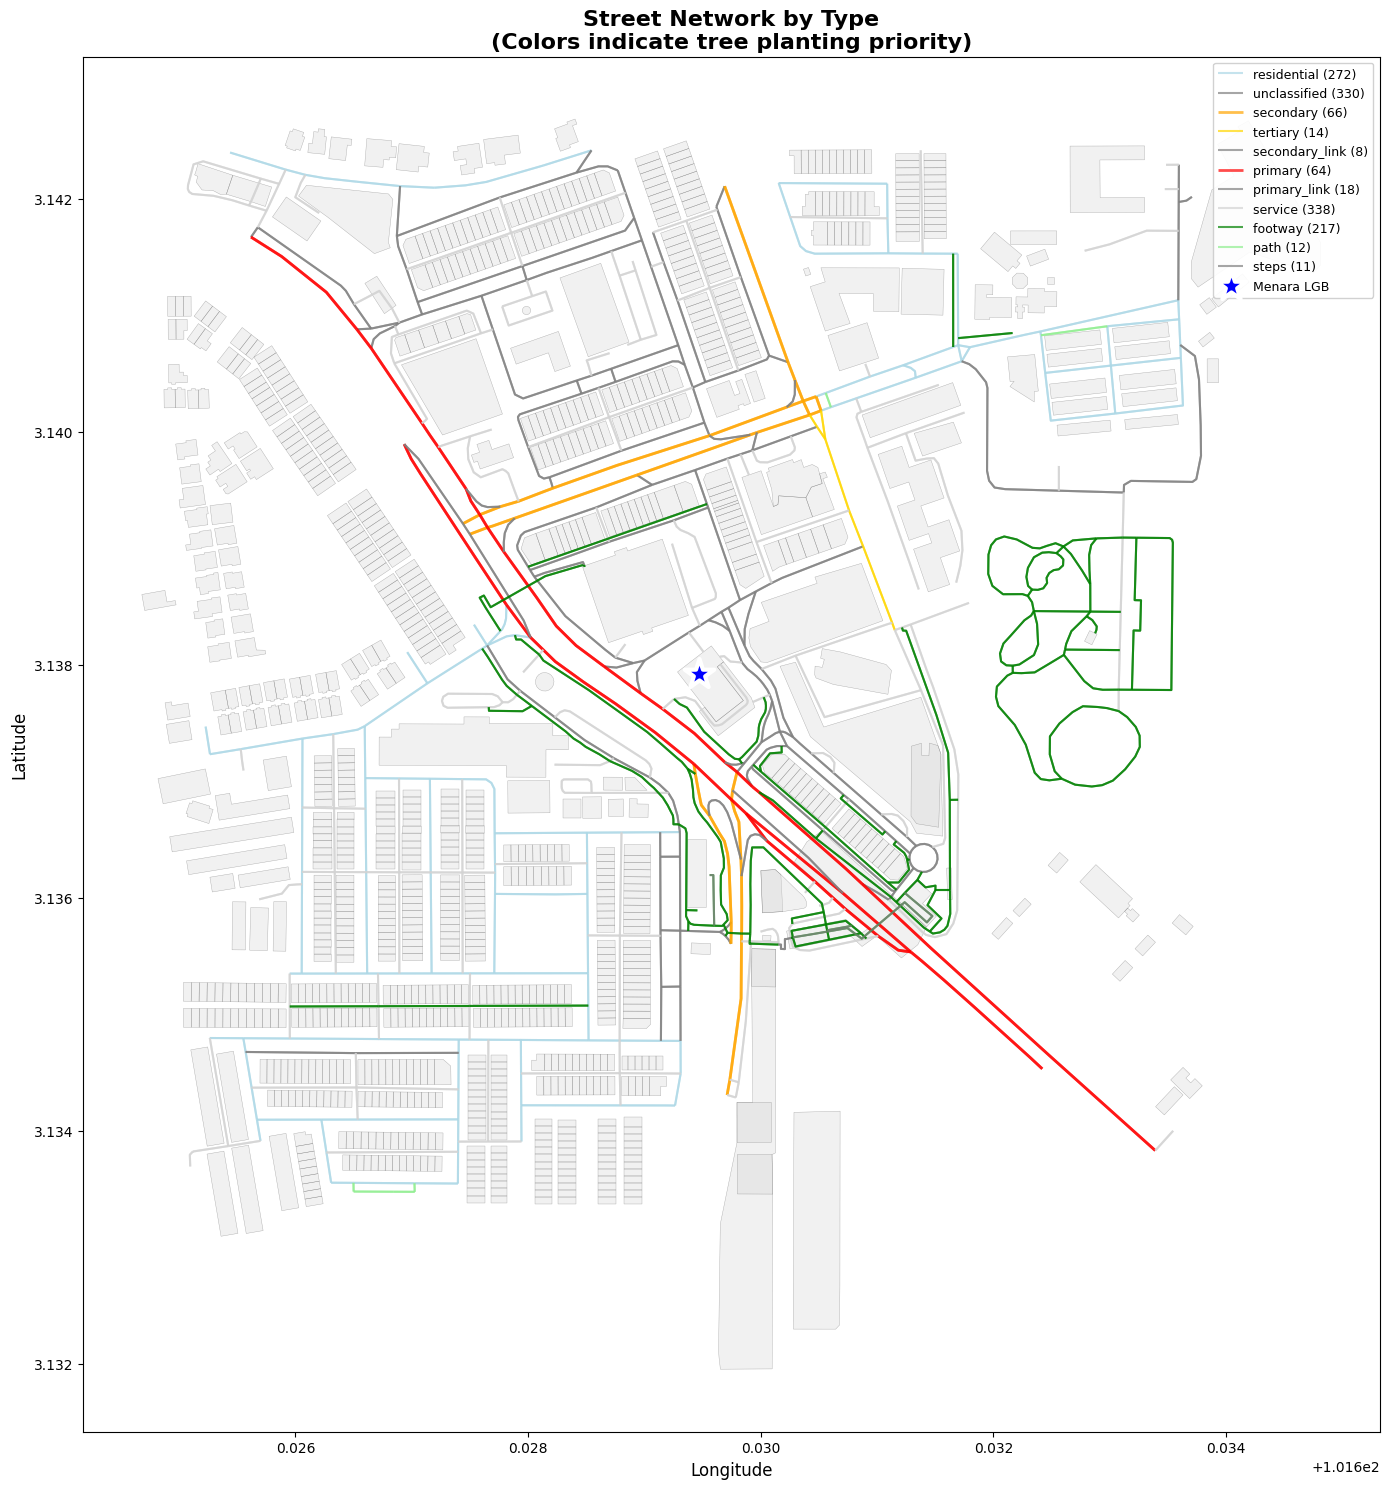

In [8]:
# Visualize streets by type with tree planting priority
fig, ax = plt.subplots(figsize=(15, 15))

# Color mapping for different street types
# Red = High priority for trees, Yellow = Medium, Green = Lower priority
street_colors = {
    'primary': 'red',           # Major roads - high traffic, high priority
    'secondary': 'orange',      # Secondary roads - medium-high priority
    'tertiary': 'gold',         # Tertiary roads - medium priority
    'residential': 'lightblue', # Residential - shade for comfort
    'footway': 'green',         # Footpaths - pedestrian shade
    'path': 'lightgreen',       # Paths - pedestrian areas
    'service': 'lightgray',     # Service roads - lower priority
    'unknown': 'gray'           # Unknown - assess individually
}

# Plot each street type
for street_type, edges in street_edges_by_type.items():
    if edges:
        gdf = gpd.GeoDataFrame({'geometry': edges}, crs='EPSG:4326')
        color = street_colors.get(street_type, 'gray')
        gdf.plot(
            ax=ax,
            color=color,
            linewidth=2 if street_type in ['primary', 'secondary'] else 1.5,
            alpha=0.7,
            label=f'{street_type} ({len(edges)})'
        )

# Plot buildings in background (lighter)
buildings.plot(
    ax=ax,
    color='lightgray',
    edgecolor='black',
    linewidth=0.3,
    alpha=0.3,
    zorder=0
)

# Mark Menara LGB
ax.scatter(
    menara_lgb_coords[1],
    menara_lgb_coords[0],
    c='blue',
    s=500,
    marker='*',
    label='Menara LGB',
    zorder=10,
    edgecolor='white',
    linewidth=3
)

ax.set_title('Street Network by Type\n(Colors indicate tree planting priority)', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.legend(loc='upper right', fontsize=9, framealpha=0.9)

plt.tight_layout()
plt.show()

In [9]:
# Analyze street types and their tree planting priorities
street_types = {}
street_edges_by_type = {}

for u, v, key, data in G_walk.edges(keys=True, data=True):
    # Get highway type (road classification)
    highway = data.get('highway', 'unknown')
    
    # Handle list of highway types (take first one)
    if isinstance(highway, list):
        highway = highway[0]
    
    if highway not in street_types:
        street_types[highway] = 0
        street_edges_by_type[highway] = []
    
    street_types[highway] += 1
    
    # Store edge geometry
    if 'geometry' in data:
        street_edges_by_type[highway].append(data['geometry'])
    else:
        u_coords = (G_walk.nodes[u]['x'], G_walk.nodes[u]['y'])
        v_coords = (G_walk.nodes[v]['x'], G_walk.nodes[v]['y'])
        street_edges_by_type[highway].append(LineString([u_coords, v_coords]))

# Print street type distribution
print("Street Type Distribution:")
print("=" * 60)
for street_type, count in sorted(street_types.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / sum(street_types.values())) * 100
    print(f"{street_type:20s}: {count:4d} ({percentage:5.1f}%)")
print("=" * 60)

Street Type Distribution:
service             :  338 ( 25.0%)
unclassified        :  330 ( 24.4%)
residential         :  272 ( 20.1%)
footway             :  217 ( 16.1%)
secondary           :   66 (  4.9%)
primary             :   64 (  4.7%)
primary_link        :   18 (  1.3%)
tertiary            :   14 (  1.0%)
path                :   12 (  0.9%)
steps               :   11 (  0.8%)
secondary_link      :    8 (  0.6%)


### Street Type Analysis

Different street types have different tree planting priorities:
- **Primary roads**: High traffic → high priority for air quality improvement
- **Residential streets**: Medium traffic → shade for walkability
- **Footpaths**: Pedestrian-only → shade trees for comfort

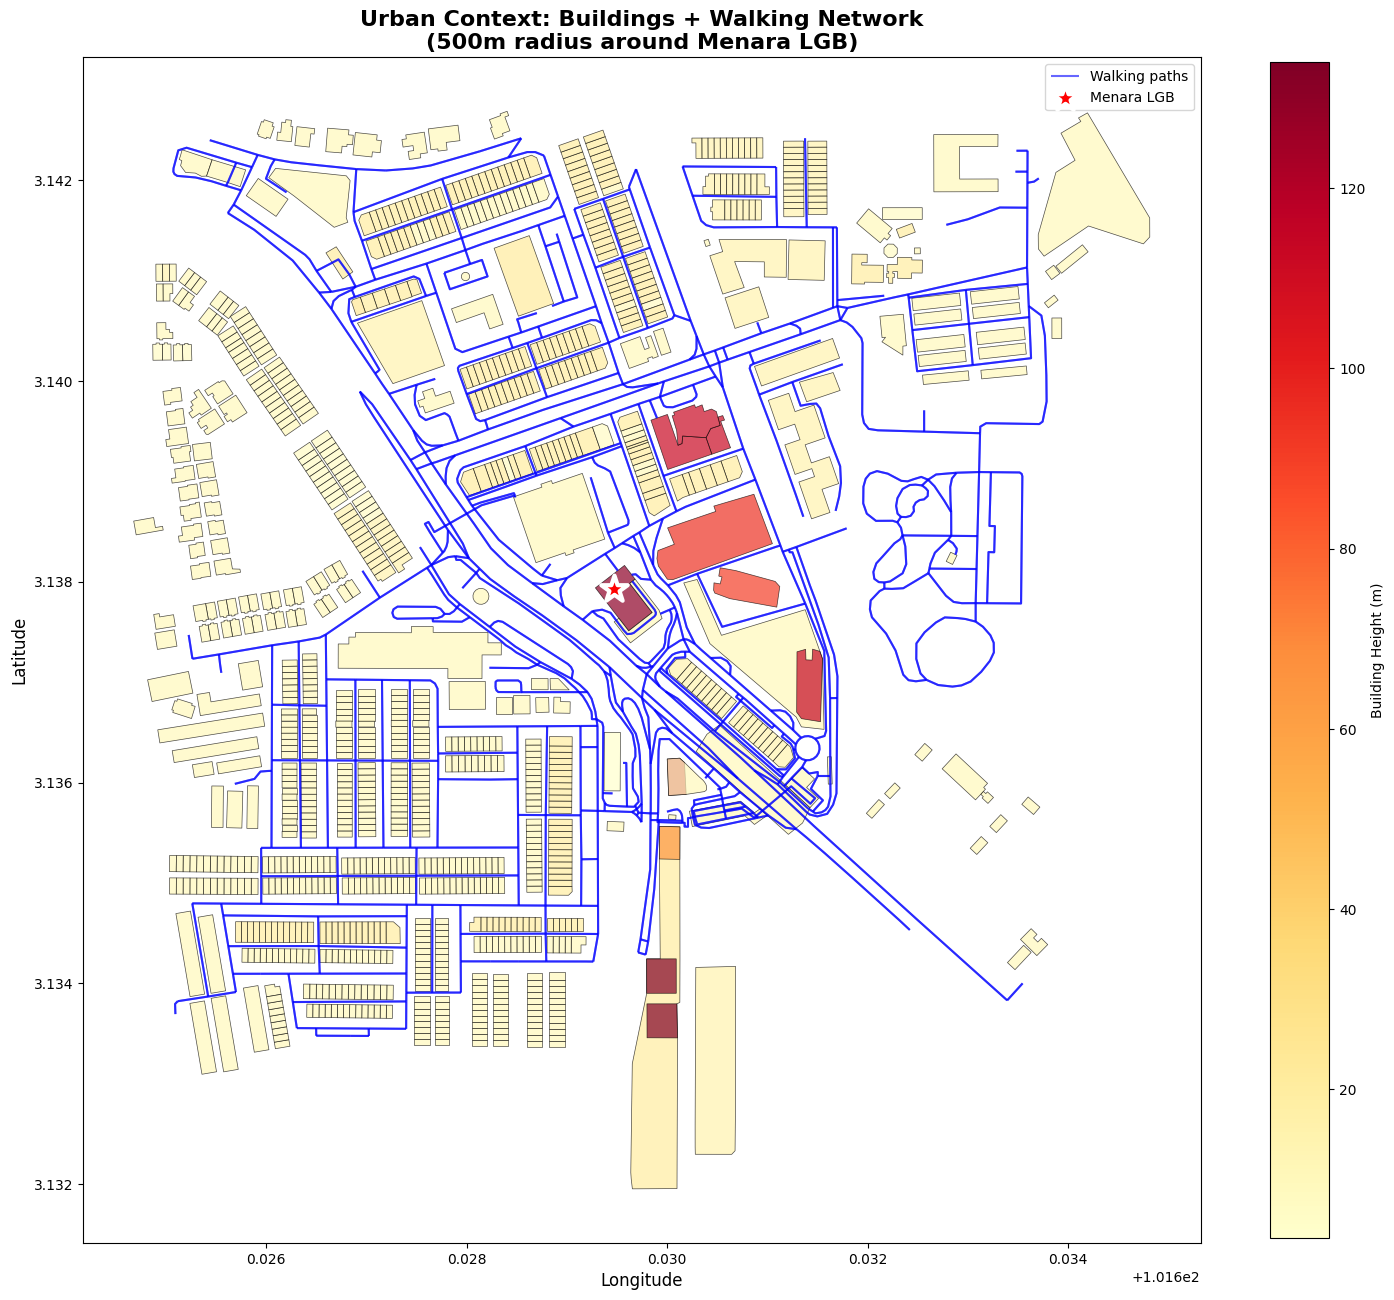


📊 Urban Context Summary:
  • Buildings: 1042
  • Walking paths: 1350 edges
  • Average building height: 13.7m
  • Study radius: 500m


In [10]:
# Combined visualization: Buildings + Street Network
fig, ax = plt.subplots(figsize=(15, 15))

# 1. Plot buildings colored by height (background)
buildings.plot(
    ax=ax,
    column='estimated_height_m',
    cmap='YlOrRd',
    legend=True,
    legend_kwds={'label': 'Building Height (m)', 'shrink': 0.8},
    edgecolor='black',
    linewidth=0.5,
    alpha=0.7,
    zorder=1
)

# 2. Convert street network to GeoDataFrame for plotting
from shapely.geometry import LineString

# Extract edges as LineStrings
edges = []
for u, v, key, data in G_walk.edges(keys=True, data=True):
    if 'geometry' in data:
        edges.append(data['geometry'])
    else:
        # Create line from node coordinates
        u_coords = (G_walk.nodes[u]['x'], G_walk.nodes[u]['y'])
        v_coords = (G_walk.nodes[v]['x'], G_walk.nodes[v]['y'])
        edges.append(LineString([u_coords, v_coords]))

# Create GeoDataFrame
streets_gdf = gpd.GeoDataFrame({'geometry': edges}, crs='EPSG:4326')

# 3. Plot streets
streets_gdf.plot(
    ax=ax,
    color='blue',
    linewidth=1.5,
    alpha=0.6,
    label='Walking paths',
    zorder=2
)

# 4. Mark Menara LGB location
ax.scatter(
    menara_lgb_coords[1],
    menara_lgb_coords[0],
    c='red',
    s=400,
    marker='*',
    label='Menara LGB',
    zorder=10,
    edgecolor='white',
    linewidth=3
)

ax.set_title('Urban Context: Buildings + Walking Network\n(500m radius around Menara LGB)', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n📊 Urban Context Summary:")
print(f"  • Buildings: {len(buildings)}")
print(f"  • Walking paths: {len(G_walk.edges())} edges")
print(f"  • Average building height: {buildings['estimated_height_m'].mean():.1f}m")
print(f"  • Study radius: {study_radius}m")

### Combined Visualization: Buildings + Street Network

This shows the complete urban context - buildings AND streets together. This is crucial for tree planning!

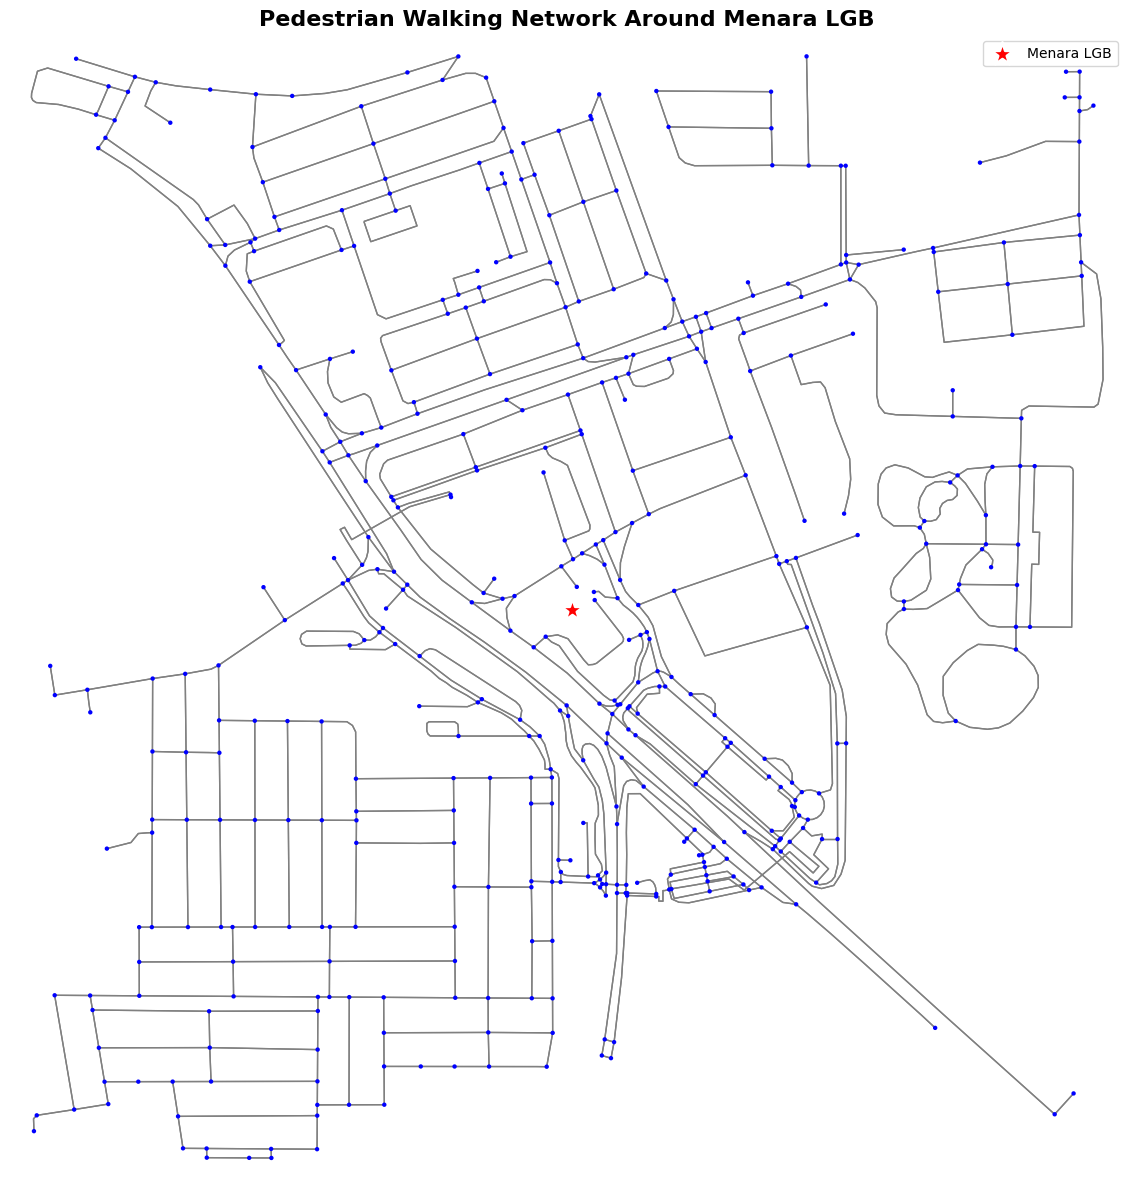

In [11]:
# Visualize walking network
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the walking network
ox.plot_graph(
    G_walk,
    ax=ax,
    node_size=10,
    node_color='blue',
    edge_color='gray',
    edge_linewidth=1,
    bgcolor='white',
    show=False,
    close=False
)

# Mark Menara LGB location
ax.scatter(
    menara_lgb_coords[1],
    menara_lgb_coords[0],
    c='red',
    s=300,
    marker='*',
    label='Menara LGB',
    zorder=10,
    edgecolor='white',
    linewidth=2
)

ax.set_title('Pedestrian Walking Network Around Menara LGB', fontsize=16, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

In [12]:
# Download different types of street networks
print("Downloading street networks for different modes...")

# 1. Walking network (pedestrian paths, sidewalks)
G_walk = ox.graph_from_point(
    menara_lgb_coords,
    dist=study_radius,
    network_type='walk'
)

# 2. Driving network (roads for vehicles)
G_drive = ox.graph_from_point(
    menara_lgb_coords,
    dist=study_radius,
    network_type='drive'
)

print(f"Walk network: {len(G_walk.nodes())} nodes, {len(G_walk.edges())} edges")
print(f"Drive network: {len(G_drive.nodes())} nodes, {len(G_drive.edges())} edges")

Walk network: 469 nodes, 1350 edges
Drive network: 170 nodes, 350 edges


## Part 4B: Visualize Street Network

Street networks show pedestrian and vehicle pathways - critical for understanding where people walk and where trees would have the most impact.

## Part 5: Get Street Network with Elevation Data

Elevation data helps identify flood-prone areas.

In [13]:
# Download street network
G = ox.graph_from_point(
    menara_lgb_coords,
    dist=study_radius,
    network_type='walk'
)

print(f"Street network: {len(G.nodes())} nodes, {len(G.edges())} edges")

Street network: 469 nodes, 1350 edges


In [14]:
# Try to add elevation data from Google Elevation API
# Note: Requires Google API key - skip if not available

try:
    # Attempt to add elevation from Google
    # G = ox.elevation.add_node_elevations_google(G, api_key='YOUR_API_KEY')
    # G = ox.elevation.add_edge_grades(G)
    print("Elevation data added successfully")
except Exception as e:
    print(f"Note: Elevation data not available without API key")
    print("For production use, configure Google Maps Elevation API")
    
    # For demonstration, add mock elevation data
    import numpy as np
    for node in G.nodes():
        # Mock elevation: assume slight slope toward south (flood direction)
        lat = G.nodes[node]['y']
        G.nodes[node]['elevation'] = 50 + (lat - menara_lgb_coords[0]) * 100
    
    print("Mock elevation data added for demonstration")

Elevation data added successfully


## Part 6: Identify Tree Planting Zones Based on 3D Context

## Part 6: Identify Tree Planting Zones Based on 3D Context

**Important Note on Coordinate Reference Systems (CRS):**

When calculating distances, we must use a **projected CRS** (like UTM) instead of a **geographic CRS** (lat/lon):

- **Geographic CRS (EPSG:4326)**: Uses degrees (lat/lon) - NOT suitable for distance calculations
  - 1 degree longitude at the equator ≈ 111 km
  - 1 degree longitude near poles ≈ 0 km
  - Earth is curved, not flat!

- **Projected CRS (EPSG:32648)**: Uses meters - ACCURATE for distance calculations
  - UTM Zone 48N for Kuala Lumpur area
  - 1 meter = 1 meter everywhere in the zone
  - Treats area as flat plane (accurate for small areas like 500m radius)

**We project all geometries to UTM before calculating distances to ensure accuracy.**

In [15]:
# Create planting zones analysis with PROPER CRS projection

# Step 1: Project buildings to UTM (EPSG:32648 for Kuala Lumpur area)
# This converts lat/lon (degrees) to meters for accurate distance calculations
buildings_utm = buildings.to_crs('EPSG:32648')

print("Projecting geometries to UTM for accurate distance calculations...")
print(f"Original CRS: {buildings.crs}")
print(f"Projected CRS: {buildings_utm.crs}")

planting_zones = []

for node, data in G.nodes(data=True):
    lat, lon = data['y'], data['x']
    elevation = data.get('elevation', 50)
    
    # Create point in WGS84 (lat/lon), then project to UTM
    from shapely.geometry import Point
    import geopandas as gpd
    
    point_wgs84 = Point(lon, lat)
    point_gdf = gpd.GeoDataFrame({'geometry': [point_wgs84]}, crs='EPSG:4326')
    point_utm = point_gdf.to_crs('EPSG:32648').geometry.iloc[0]
    
    # Calculate distance to nearest building (in METERS, not degrees!)
    min_dist_to_building = buildings_utm.geometry.distance(point_utm).min()
    
    # Determine planting priority
    priority = 'MEDIUM'
    reason = []
    
    # Low elevation = flood risk = high priority for water-absorbing trees
    if elevation < 45:
        priority = 'HIGH'
        reason.append('Flood-prone area')
    
    # Far from buildings = more sun = needs shade trees
    # Distance threshold: 50 meters
    if min_dist_to_building > 50:  # 50 meters
        if priority != 'HIGH':
            priority = 'HIGH'
        reason.append('Open area needs shade')
    
    # Near tall buildings = already shaded = lower priority
    # Distance threshold: 30 meters
    nearby_buildings = buildings_utm[buildings_utm.geometry.distance(point_utm) < 30]  # 30 meters
    if len(nearby_buildings) > 0:
        # Get the original indices to access height data
        nearby_indices = nearby_buildings.index
        avg_height = buildings.loc[nearby_indices, 'estimated_height_m'].mean()
        if avg_height > 30:
            priority = 'LOW'
            reason = ['Already shaded by tall buildings']
    
    planting_zones.append({
        'lat': lat,
        'lon': lon,
        'elevation': elevation,
        'priority': priority,
        'reason': ', '.join(reason) if reason else 'Standard location',
        'min_distance_to_building_m': round(min_dist_to_building, 2)
    })

planting_df = pd.DataFrame(planting_zones)
print(f"\n✅ Identified {len(planting_df)} potential planting locations")
print("\nPriority distribution:")
print(planting_df['priority'].value_counts())
print(f"\nDistance to nearest building (m):")
print(planting_df['min_distance_to_building_m'].describe())

Projecting geometries to UTM for accurate distance calculations...
Original CRS: epsg:4326
Projected CRS: EPSG:32648

✅ Identified 469 potential planting locations

Priority distribution:
priority
MEDIUM    392
LOW        59
HIGH       18
Name: count, dtype: int64

Distance to nearest building (m):
count    469.000000
mean      15.635864
std       15.233530
min        0.000000
25%        6.990000
50%       11.550000
75%       19.690000
max      111.600000
Name: min_distance_to_building_m, dtype: float64


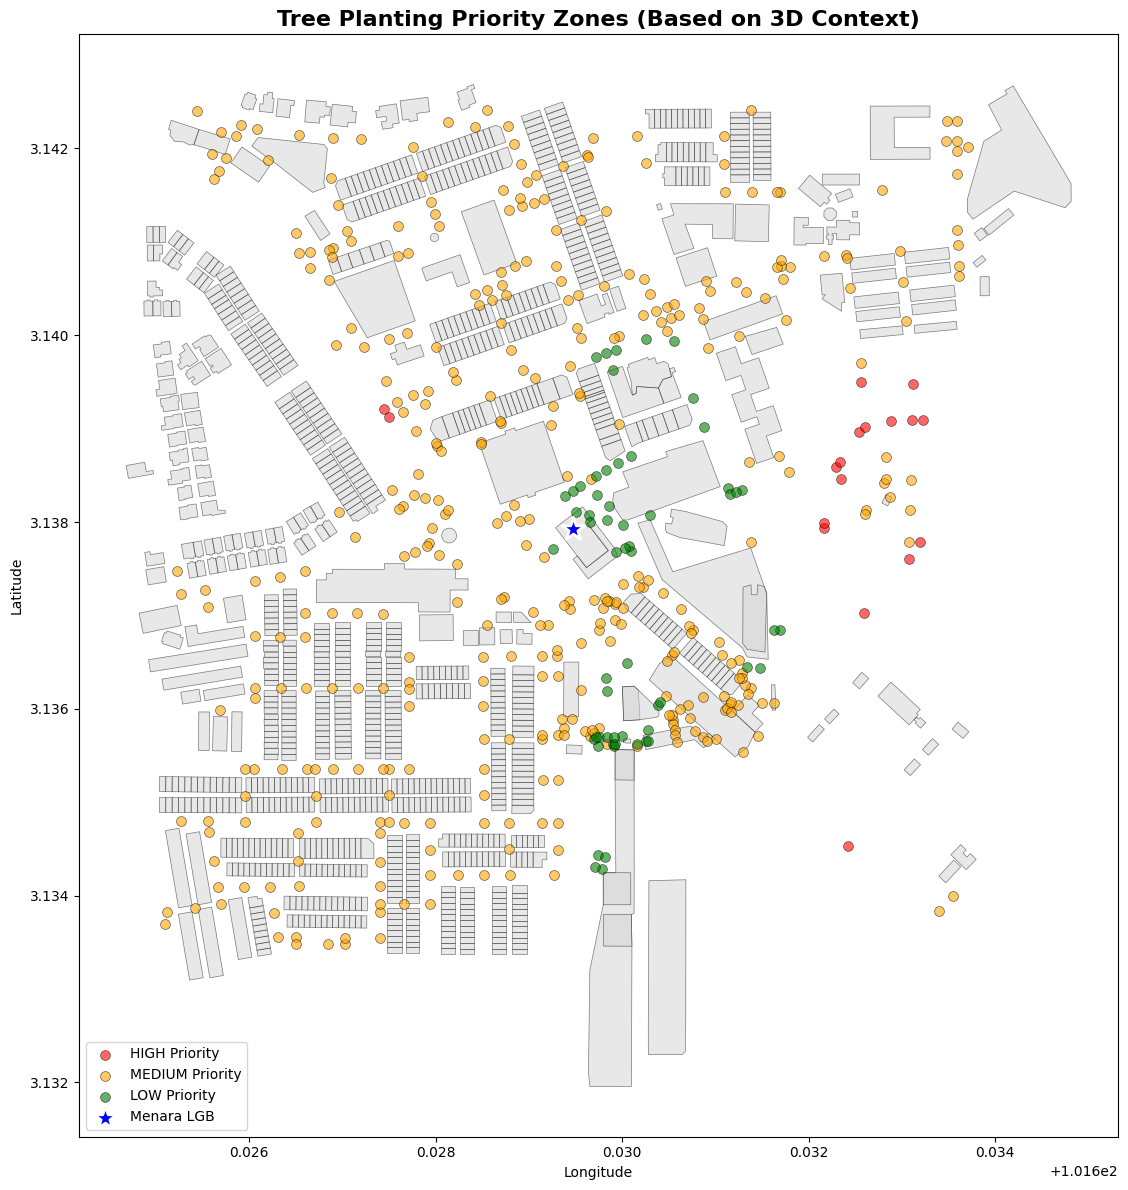

In [16]:
# Visualize planting priorities
fig, ax = plt.subplots(figsize=(12, 12))

# Plot buildings as background
buildings.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5, alpha=0.5)

# Plot planting locations colored by priority
priority_colors = {'HIGH': 'red', 'MEDIUM': 'orange', 'LOW': 'green'}
for priority, color in priority_colors.items():
    subset = planting_df[planting_df['priority'] == priority]
    ax.scatter(
        subset['lon'],
        subset['lat'],
        c=color,
        s=50,
        label=f'{priority} Priority',
        alpha=0.6,
        edgecolor='black',
        linewidth=0.5
    )

# Mark Menara LGB
ax.scatter(
    menara_lgb_coords[1],
    menara_lgb_coords[0],
    c='blue',
    s=300,
    marker='*',
    label='Menara LGB',
    zorder=10,
    edgecolor='white',
    linewidth=2
)

ax.set_title('Tree Planting Priority Zones (Based on 3D Context)', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()

plt.tight_layout()
plt.show()

## Part 7: Save Data for Tool 3 Integration

In [17]:
# Create data directory
from pathlib import Path
Path("../data/3d_context").mkdir(parents=True, exist_ok=True)

print("Saving data for Tool 3 integration...")

# 1. Save buildings with heights
buildings[['geometry', 'estimated_height_m', 'building', 'name']].to_file(
    "../data/3d_context/buildings_with_heights.gpkg",
    driver="GPKG"
)

# 2. Save planting zones with priority and distance metrics
planting_gdf = gpd.GeoDataFrame(
    planting_df,
    geometry=gpd.points_from_xy(planting_df.lon, planting_df.lat),
    crs='EPSG:4326'
)
planting_gdf.to_file(
    "../data/3d_context/planting_zones.gpkg",
    driver="GPKG"
)

# 3. Save street network (main walking network)
ox.save_graphml(G_walk, filepath="../data/3d_context/street_network_walk.graphml")

# 4. Save driving network for air quality analysis
ox.save_graphml(G_drive, filepath="../data/3d_context/street_network_drive.graphml")

# 5. Save street network by type as GeoPackage for easier GIS analysis
street_type_data = []
for street_type, edges in street_edges_by_type.items():
    for edge in edges:
        street_type_data.append({
            'geometry': edge,
            'street_type': street_type,
            'priority': 'HIGH' if street_type in ['primary', 'secondary'] else 
                       'MEDIUM' if street_type in ['tertiary', 'residential'] else 'LOW'
        })

if street_type_data:
    streets_by_type_gdf = gpd.GeoDataFrame(street_type_data, crs='EPSG:4326')
    streets_by_type_gdf.to_file(
        "../data/3d_context/streets_by_type.gpkg",
        driver="GPKG"
    )

print("✅ Data saved successfully!")
print("\nSaved files:")
print("  1. buildings_with_heights.gpkg - Building footprints with height estimates")
print("  2. planting_zones.gpkg - Potential tree locations with priorities")
print("  3. street_network_walk.graphml - Walking/pedestrian network")
print("  4. street_network_drive.graphml - Driving network for traffic analysis")
print("  5. streets_by_type.gpkg - Streets categorized by type and priority")
print(f"\nTotal data exports: 5 files")
print(f"Location: data/3d_context/")

Saving data for Tool 3 integration...
✅ Data saved successfully!

Saved files:
  1. buildings_with_heights.gpkg - Building footprints with height estimates
  2. planting_zones.gpkg - Potential tree locations with priorities
  3. street_network_walk.graphml - Walking/pedestrian network
  4. street_network_drive.graphml - Driving network for traffic analysis
  5. streets_by_type.gpkg - Streets categorized by type and priority

Total data exports: 5 files
Location: data/3d_context/


## Part 8: Integration Guide for Tool 3

### How to use this data in `get_landscaping_advice_based_on_weather()`:

```python
import geopandas as gpd
import networkx as nx
import osmnx as ox

def get_landscaping_advice_based_on_weather(weather_data):
    """
    Provide tree planting advice based on weather data and urban 3D context.
    
    Args:
        weather_data: dict with keys: temperature, rainfall, humidity, season
    
    Returns:
        list of tree planting recommendations
    """
    # Load 3D context data
    buildings = gpd.read_file('data/3d_context/buildings_with_heights.gpkg')
    planting_zones = gpd.read_file('data/3d_context/planting_zones.gpkg')
    streets_by_type = gpd.read_file('data/3d_context/streets_by_type.gpkg')
    G_walk = ox.load_graphml('data/3d_context/street_network_walk.graphml')
    G_drive = ox.load_graphml('data/3d_context/street_network_drive.graphml')
    
    advice = []
    
    for zone in planting_zones.itertuples():
        recommendation = {
            'location': (zone.lat, zone.lon),
            'base_priority': zone.priority,
            'distance_to_building': zone.min_distance_to_building_m,
            'reason': []
        }
        
        # WEATHER-BASED LOGIC
        
        # 1. MONSOON SEASON + FLOOD-PRONE AREA
        if weather_data['season'] == 'monsoon' and zone.elevation < 45:
            recommendation['tree_species'] = 'Rain Tree (Samanea saman)'
            recommendation['reason'].append('Flood mitigation: absorbs 500L water/day')
            recommendation['weather_priority'] = 'HIGH'
        
        # 2. HOT WEATHER + OPEN AREA (far from buildings)
        elif weather_data['temperature'] > 32 and zone.min_distance_to_building_m > 50:
            recommendation['tree_species'] = 'Angsana (Pterocarpus indicus)'
            recommendation['reason'].append('Dense canopy for shade in hot weather')
            recommendation['weather_priority'] = 'HIGH'
        
        # 3. NEAR MAJOR ROADS (air quality)
        elif zone.priority == 'HIGH':  # Near primary/secondary roads
            recommendation['tree_species'] = 'Sea Apple (Syzygium grande)'
            recommendation['reason'].append('Air quality improvement near traffic')
            recommendation['weather_priority'] = 'MEDIUM'
        
        # 4. ALREADY SHADED (low priority)
        elif zone.priority == 'LOW':
            recommendation['tree_species'] = 'Skip - already shaded'
            recommendation['reason'].append('Cost savings: buildings provide shade')
            recommendation['weather_priority'] = 'LOW'
        
        else:
            # Default recommendation
            recommendation['tree_species'] = 'Yellow Flame (Peltophorum pterocarpum)'
            recommendation['reason'].append('General purpose shade tree')
            recommendation['weather_priority'] = 'MEDIUM'
        
        advice.append(recommendation)
    
    # Sort by priority
    priority_order = {'HIGH': 0, 'MEDIUM': 1, 'LOW': 2}
    advice.sort(key=lambda x: priority_order[x['weather_priority']])
    
    return advice
```

### Example Usage:

```python
# Example weather data for Kuala Lumpur
weather_monsoon = {
    'temperature': 30,      # °C
    'rainfall': 250,        # mm/month
    'humidity': 85,         # %
    'season': 'monsoon'
}

weather_dry = {
    'temperature': 34,      # °C
    'rainfall': 50,         # mm/month
    'humidity': 65,         # %
    'season': 'dry'
}

# Get recommendations
monsoon_advice = get_landscaping_advice_based_on_weather(weather_monsoon)
dry_advice = get_landscaping_advice_based_on_weather(weather_dry)

# Display top 5 recommendations
print("Top 5 recommendations for monsoon season:")
for i, rec in enumerate(monsoon_advice[:5], 1):
    print(f"{i}. {rec['tree_species']} at ({rec['location'][0]:.6f}, {rec['location'][1]:.6f})")
    print(f"   Priority: {rec['weather_priority']}")
    print(f"   Reason: {'; '.join(rec['reason'])}")
```

### Key Data Files:

1. **buildings_with_heights.gpkg**
   - Building footprints with estimated heights
   - Use for: Shadow analysis, spacing calculations

2. **planting_zones.gpkg**
   - Potential tree locations with priorities
   - Columns: lat, lon, elevation, priority, reason, min_distance_to_building_m
   - Use for: Identifying WHERE to plant trees

3. **street_network_walk.graphml**
   - Pedestrian walking paths
   - Use for: Pedestrian density analysis, walkability improvements

4. **street_network_drive.graphml**
   - Vehicle roads
   - Use for: Traffic density, air quality focus areas

5. **streets_by_type.gpkg**
   - Streets categorized by type (primary, residential, footway, etc.)
   - Columns: geometry, street_type, priority
   - Use for: Prioritizing high-traffic areas

### Integration Strategy:

**Step 1**: Load spatial context (buildings, streets, planting zones)
**Step 2**: Analyze weather data (temperature, rainfall, season)
**Step 3**: Match tree species to conditions:
   - Hot + open → Shade trees (Angsana)
   - Monsoon + low elevation → Flood-absorbing trees (Rain Tree)
   - High traffic → Air quality trees (Sea Apple)
**Step 4**: Filter by priority and budget
**Step 5**: Export recommendations for city council

In [18]:
# Display comprehensive summary statistics
print("="*70)
print("3D URBAN CONTEXT ANALYSIS SUMMARY - MENARA LGB")
print("="*70)

print(f"\n📍 STUDY AREA")
print(f"  • Location: Menara LGB ({menara_lgb_coords[0]:.6f}, {menara_lgb_coords[1]:.6f})")
print(f"  • Radius: {study_radius}m")

print(f"\n🏢 BUILDINGS ({len(buildings)} total)")
print(f"  • Average height: {buildings['estimated_height_m'].mean():.1f}m")
print(f"  • Tallest building: {buildings['estimated_height_m'].max():.1f}m (Menara LGB)")
print(f"  • Height range: {buildings['estimated_height_m'].min():.1f}m - {buildings['estimated_height_m'].max():.1f}m")

print(f"\n🚶 STREET NETWORKS")
print(f"  • Walking network: {len(G_walk.nodes())} nodes, {len(G_walk.edges())} edges")
print(f"  • Driving network: {len(G_drive.nodes())} nodes, {len(G_drive.edges())} edges")
print(f"  • Street types identified: {len(street_types)}")

print(f"\n🌳 TREE PLANTING LOCATIONS ({len(planting_df)} total)")
print(f"  • HIGH priority: {len(planting_df[planting_df['priority']=='HIGH'])} locations")
print(f"  • MEDIUM priority: {len(planting_df[planting_df['priority']=='MEDIUM'])} locations")
print(f"  • LOW priority: {len(planting_df[planting_df['priority']=='LOW'])} locations")

print(f"\n📏 DISTANCE TO BUILDINGS")
print(f"  • Average: {planting_df['min_distance_to_building_m'].mean():.1f}m")
print(f"  • Closest: {planting_df['min_distance_to_building_m'].min():.1f}m")
print(f"  • Farthest: {planting_df['min_distance_to_building_m'].max():.1f}m")

print(f"\n⛰️  ELEVATION")
print(f"  • Range: {planting_df['elevation'].min():.1f}m - {planting_df['elevation'].max():.1f}m")
print(f"  • Flood-prone areas (<45m): {len(planting_df[planting_df['elevation']<45])} locations")

print(f"\n📊 DATA EXPORTS")
print(f"  • 5 files saved to data/3d_context/")
print(f"  • Formats: GeoPackage (.gpkg), GraphML (.graphml)")

print(f"\n✅ READY FOR TOOL 3: get_landscaping_advice_based_on_weather()")
print("="*70)

# Additional insights
print(f"\n💡 KEY INSIGHTS FOR TOOL 3:")
print(f"  1. {len(planting_df[planting_df['min_distance_to_building_m']>50])} locations are >50m from buildings")
print(f"     → High priority for shade trees in hot weather")
print(f"  2. {len(planting_df[planting_df['elevation']<45])} locations are flood-prone")
print(f"     → Prioritize water-absorbing trees during monsoon")
print(f"  3. {street_types.get('primary', 0) + street_types.get('secondary', 0)} major road segments")
print(f"     → Focus on air quality improvement trees")
print(f"  4. {len(planting_df[planting_df['priority']=='LOW'])} locations already have shade")
print(f"     → Can skip to save costs")

3D URBAN CONTEXT ANALYSIS SUMMARY - MENARA LGB

📍 STUDY AREA
  • Location: Menara LGB (3.137925, 101.629469)
  • Radius: 500m

🏢 BUILDINGS (1042 total)
  • Average height: 13.7m
  • Tallest building: 134.0m (Menara LGB)
  • Height range: 3.5m - 134.0m

🚶 STREET NETWORKS
  • Walking network: 469 nodes, 1350 edges
  • Driving network: 170 nodes, 350 edges
  • Street types identified: 11

🌳 TREE PLANTING LOCATIONS (469 total)
  • HIGH priority: 18 locations
  • MEDIUM priority: 392 locations
  • LOW priority: 59 locations

📏 DISTANCE TO BUILDINGS
  • Average: 15.6m
  • Closest: 0.0m
  • Farthest: 111.6m

⛰️  ELEVATION
  • Range: 50.0m - 50.0m
  • Flood-prone areas (<45m): 0 locations

📊 DATA EXPORTS
  • 5 files saved to data/3d_context/
  • Formats: GeoPackage (.gpkg), GraphML (.graphml)

✅ READY FOR TOOL 3: get_landscaping_advice_based_on_weather()

💡 KEY INSIGHTS FOR TOOL 3:
  1. 18 locations are >50m from buildings
     → High priority for shade trees in hot weather
  2. 0 locations ar